In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [33]:
user_transactions_file_directory = "C:/Users/matsbosma/Documents/Statistic Assignment/TaoYin_User_Transactions_v2.parquet"
item_file_directory = "C:/Users/matsbosma/Documents/Statistic Assignment/Tao Yin_Item_features.parquet"

df_if = pd.read_parquet(item_file_directory)
df_ut = pd.read_parquet(user_transactions_file_directory)


In [34]:
# List of columns to check for outliers
columns_to_check = ['volume', 'sum1', 'sum2']

# Detect outliers using both Modified Z-score and IQR methods
for col in columns_to_check:
    # Step 1: Calculate Modified Z-score
    median_value = df_ut[col].median()
    mad_value = (df_ut[col] - median_value).abs().median()
    df_ut[f'{col}_Modified_Z_Score'] = 0.6745 * (df_ut[col] - median_value) / mad_value

    # Step 2: Calculate IQR for Tukey's Outlier Detection
    Q1 = df_ut[col].quantile(0.25)
    Q3 = df_ut[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Step 3: Flag Outliers
    df_ut[f'{col}_Outlier_Modified_Z'] = df_ut[f'{col}_Modified_Z_Score'].abs() > 3.5
    df_ut[f'{col}_Outlier_IQR'] = (df_ut[col] < lower_bound) | (df_ut[col] > upper_bound)

    # Combine both methods to create a final outlier flag for the column
    df_ut[f'{col}_Outlier'] = df_ut[f'{col}_Outlier_Modified_Z'] | df_ut[f'{col}_Outlier_IQR']

# Create a final outlier column indicating if any column has an outlier
df_ut['Outlier'] = df_ut[[f'{col}_Outlier' for col in columns_to_check]].any(axis=1)

# Separate outliers and inliers
outliers_df = df_ut[df_ut['Outlier']].copy()
inliers_df = df_ut[~df_ut['Outlier']].copy()

# Add a label column to indicate these are outliers
outliers_df['Outlier_Label'] = 'Outlier'

# Add a label column to inliers for consistency (optional)
inliers_df['Outlier_Label'] = 'Inlier'

# Work with inliers_df (the dataset without outliers)
# Perform your analysis or model training on inliers_df

# After finishing the analysis, concatenate the inliers and outliers back together
final_df = pd.concat([inliers_df, outliers_df], ignore_index=True)

# Display the final dataset with labeled outliers and inliers
print(final_df)



        customer  invoice invoice_date  articlenr  volume    sum1    sum2  \
0           1704  1191447   2020-01-17   36866802       1   21.52   19.32   
1             45  1187691   2020-01-03   34360272       4   28.91   28.49   
2            812  1187640   2020-01-03   35620322       1  119.91  125.73   
3            812  1187640   2020-01-03   35621464       1  126.93  133.10   
4            812  1187640   2020-01-03   35626924       4    4.51    4.61   
...          ...      ...          ...        ...     ...     ...     ...   
492726      1184  1596593   2024-09-18   32202844     100  283.66  172.96   
492727      1571  1596665   2024-09-19   27243544     200  559.10  434.30   
492728      1571  1596666   2024-09-19   26811430     100  296.22  260.51   
492729       441  1596745   2024-09-19   32805944       4  363.66  381.85   
492730       441  1596745   2024-09-19   34100450       4  590.03  619.53   

        postcode_delivery  postcode_customer    channel  ...  \
0          

In [8]:
# Check variance in each feature
print("Variance in each feature:")
print(df_ut[['sum1', 'sum2', 'volume']].var())


Variance in each feature:
sum1      4.358476e+09
sum2      6.452453e+09
volume    7.235624e+06
dtype: float64


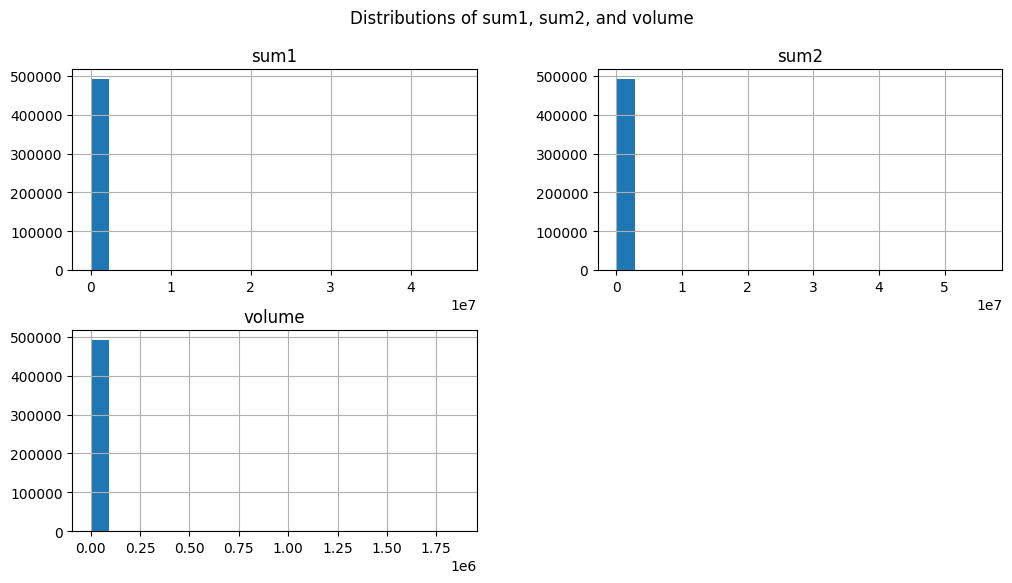

In [10]:
# Plot histograms of each feature
df_ut[['sum1', 'sum2', 'volume']].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distributions of sum1, sum2, and volume')
plt.show()


In [19]:
# Apply log transformation (adding 1 to avoid log(0))
df_ut['log_sum1'] = np.log1p(df_ut['sum1'])
df_ut['log_sum2'] = np.log1p(df_ut['sum2'])
df_ut['log_volume'] = np.log1p(df_ut['volume'])

# Use transformed data for clustering
data_for_clustering = df_ut[['log_sum1', 'log_sum2', 'log_volume']].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)


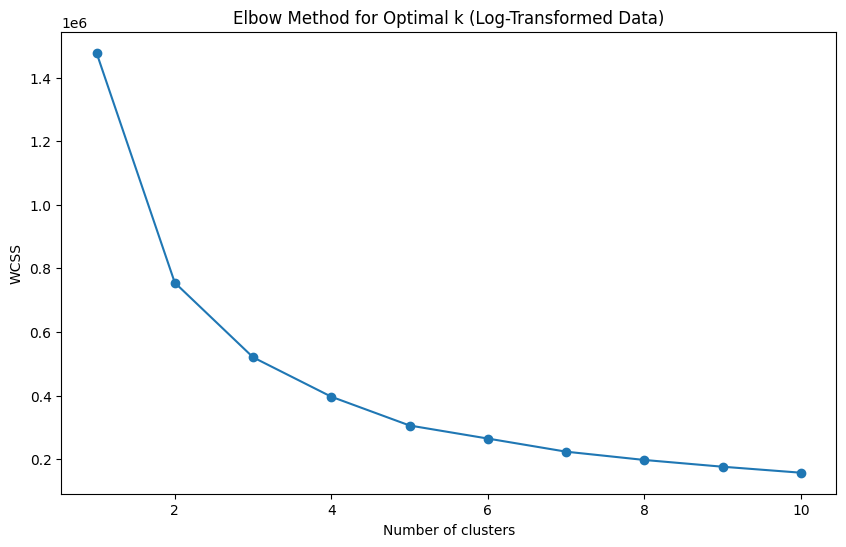

In [20]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k (Log-Transformed Data)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [21]:
# Set the optimal number of clusters based on the Elbow plot
k_optimal = 3  # Replace this with 4 if you want to try with 4 clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_ut['cluster'] = kmeans.fit_predict(data_scaled)  # Using the log-transformed, scaled data

# Display cluster assignments
print("Cluster assignments:")
print(df_ut[['log_sum1', 'log_sum2', 'log_volume', 'cluster']].head())


Cluster assignments:
   log_sum1  log_sum2  log_volume  cluster
0  5.842762  5.895229    3.218876        2
1  6.974142  7.021941    4.110874        2
2  7.703008  7.787133    4.795791        2
3  3.114404  3.011606    0.693147        0
4  3.398193  3.384051    1.609438        1


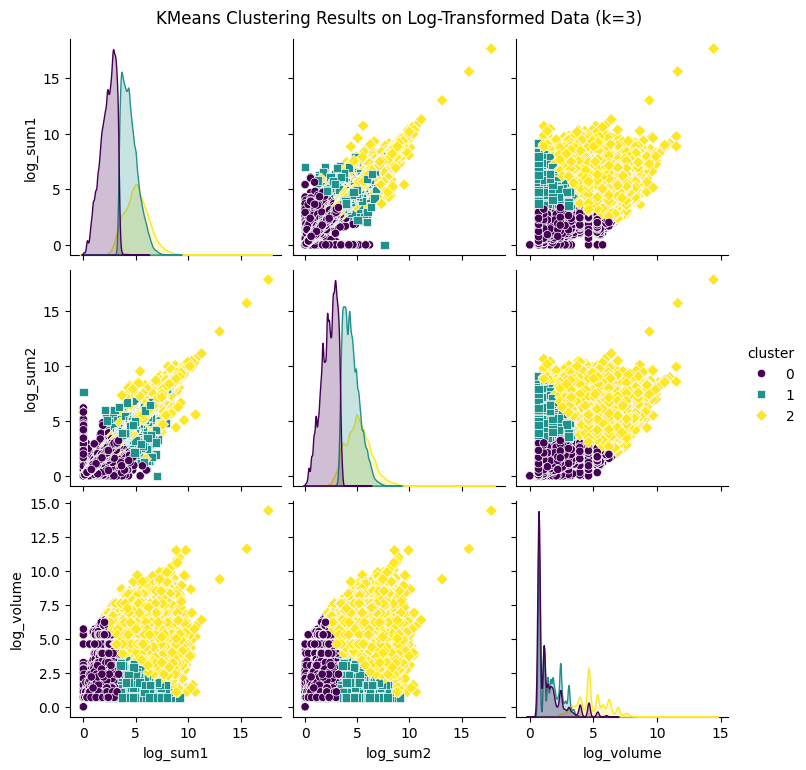

In [14]:
# Visualize clustering results with a pairplot
sns.pairplot(df_ut, vars=['log_sum1', 'log_sum2', 'log_volume'], hue='cluster', palette='viridis', markers=["o", "s", "D"])
plt.suptitle(f'KMeans Clustering Results on Log-Transformed Data (k={k_optimal})', y=1.02)
plt.show()


In [15]:
# Calculate summary statistics for each cluster
cluster_summary = df_ut.groupby('cluster')[['sum1', 'sum2', 'volume']].mean()
print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
               sum1        sum2      volume
cluster                                    
0         11.592533   11.163981   12.500733
1        121.396120  122.419735    5.967675
2        835.378129  957.895170  330.537627


In [17]:
# Avoid division by zero by filtering out rows with sum1 close to zero
df_ut = df_ut[df_ut['sum1'] > 1e-6]  # Only keep rows where sum1 is greater than a small threshold

# Recalculate profit margin
df_ut['profit_margin'] = (df_ut['sum2'] - df_ut['sum1']) / df_ut['sum1']

# Calculate the mean profit margin for each cluster again
profit_margin_summary = df_ut.groupby('cluster')['profit_margin'].mean()

print("Average Profit Margin per Cluster (after filtering zero sum1):")
print(profit_margin_summary)


Average Profit Margin per Cluster (after filtering zero sum1):
cluster
0    0.171880
1    0.028991
2    0.047848
Name: profit_margin, dtype: float64


In [18]:
# Define a function to describe each cluster
def describe_cluster(cluster_id):
    cluster_data = df_ut[df_ut['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} Summary:")
    print("Average Purchase Price (sum1):", cluster_data['sum1'].mean())
    print("Average Sales Price (sum2):", cluster_data['sum2'].mean())
    print("Average Volume:", cluster_data['volume'].mean())
    print("Average Profit Margin:", cluster_data['profit_margin'].mean())
    print("Number of Transactions:", cluster_data.shape[0])

# Apply the function to each cluster
for cluster_id in df_ut['cluster'].unique():
    describe_cluster(cluster_id)



Cluster 2 Summary:
Average Purchase Price (sum1): 835.385875082292
Average Sales Price (sum2): 957.9011148200691
Average Volume: 330.5388374270958
Average Profit Margin: 0.04784777555296248
Number of Transactions: 107847

Cluster 0 Summary:
Average Purchase Price (sum1): 11.602242986510054
Average Sales Price (sum2): 11.149352058965542
Average Volume: 12.504424386350424
Average Profit Margin: 0.1718795291252434
Number of Transactions: 202966

Cluster 1 Summary:
Average Purchase Price (sum1): 121.39678831996301
Average Sales Price (sum2): 122.40917060072847
Average Volume: 5.967581129708495
Average Profit Margin: 0.028991263132750255
Number of Transactions: 181746


In [19]:
# Generate insights based on average values in each cluster
for cluster_id in df_ut['cluster'].unique():
    cluster_data = df_ut[df_ut['cluster'] == cluster_id]
    avg_sum1 = cluster_data['sum1'].mean()
    avg_sum2 = cluster_data['sum2'].mean()
    avg_volume = cluster_data['volume'].mean()
    avg_profit_margin = cluster_data['profit_margin'].mean()
    
    print(f"\nInsights for Cluster {cluster_id}:")
    if avg_sum1 > avg_sum2:
        print(" - Purchase price is higher than sales price on average. Consider reviewing pricing or discount strategies.")
    if avg_volume > df_ut['volume'].mean():
        print(" - High average volume. Ensure adequate inventory to meet demand.")
    else:
        print(" - Lower average volume. Monitor demand or consider promotions to boost sales.")
    
    if avg_profit_margin < 0.1:
        print(" - Low profit margin. Consider adjusting sales price or reducing purchase costs.")
    else:
        print(" - Good profit margin. Maintain current pricing and cost structure.")



Insights for Cluster 2:
 - High average volume. Ensure adequate inventory to meet demand.
 - Low profit margin. Consider adjusting sales price or reducing purchase costs.

Insights for Cluster 0:
 - Purchase price is higher than sales price on average. Consider reviewing pricing or discount strategies.
 - Lower average volume. Monitor demand or consider promotions to boost sales.
 - Good profit margin. Maintain current pricing and cost structure.

Insights for Cluster 1:
 - Lower average volume. Monitor demand or consider promotions to boost sales.
 - Low profit margin. Consider adjusting sales price or reducing purchase costs.


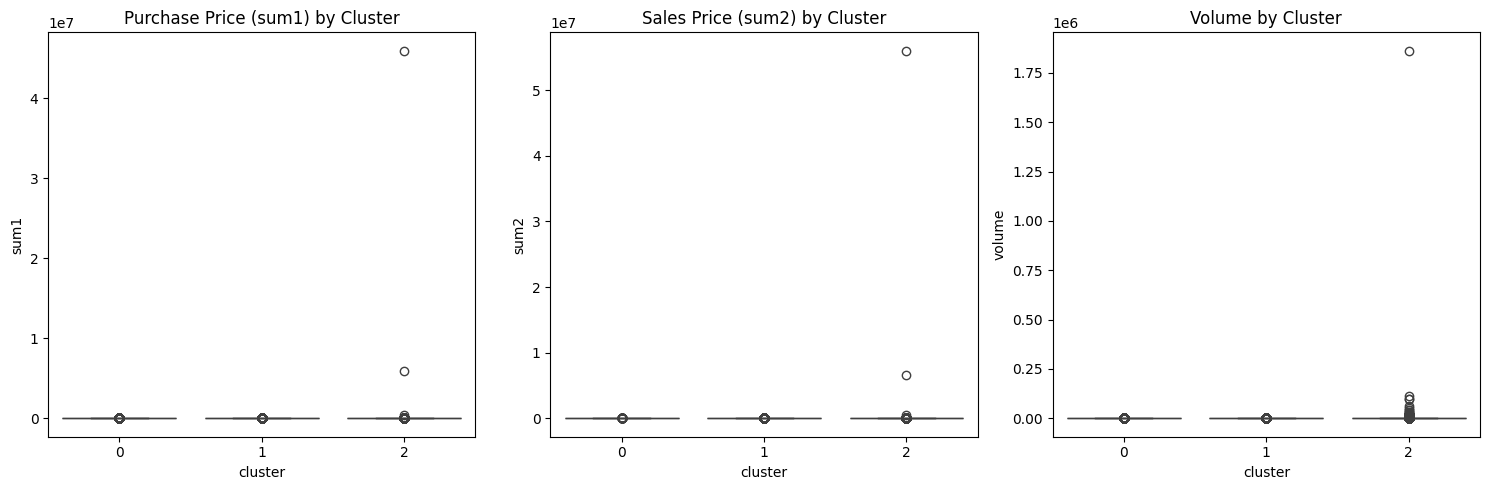

In [20]:
# Box plots to visualize distributions in each cluster
plt.figure(figsize=(15, 5))

# Box plot for Purchase Price (sum1) by cluster
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster', y='sum1', data=df_ut)
plt.title('Purchase Price (sum1) by Cluster')

# Box plot for Sales Price (sum2) by cluster
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster', y='sum2', data=df_ut)
plt.title('Sales Price (sum2) by Cluster')

# Box plot for Volume by cluster
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster', y='volume', data=df_ut)
plt.title('Volume by Cluster')

plt.tight_layout()
plt.show()


In [4]:
# Convert the invoice_date column to datetime format if not already
df_ut['invoice_date'] = pd.to_datetime(df_ut['invoice_date'])

# Extract year and month for time-based aggregation
df_ut['year'] = df_ut['invoice_date'].dt.year
df_ut['month'] = df_ut['invoice_date'].dt.month


In [8]:
# Aggregate sales volume by year and month
monthly_sales_volume = final_df.groupby(['year', 'month'])['volume'].sum().reset_index()

print("Monthly Sales Volume:")
print(monthly_sales_volume.head())


Monthly Sales Volume:
   year  month  volume
0  2020      1  899438
1  2020      2  749898
2  2020      3  837770
3  2020      4  752213
4  2020      5  880662


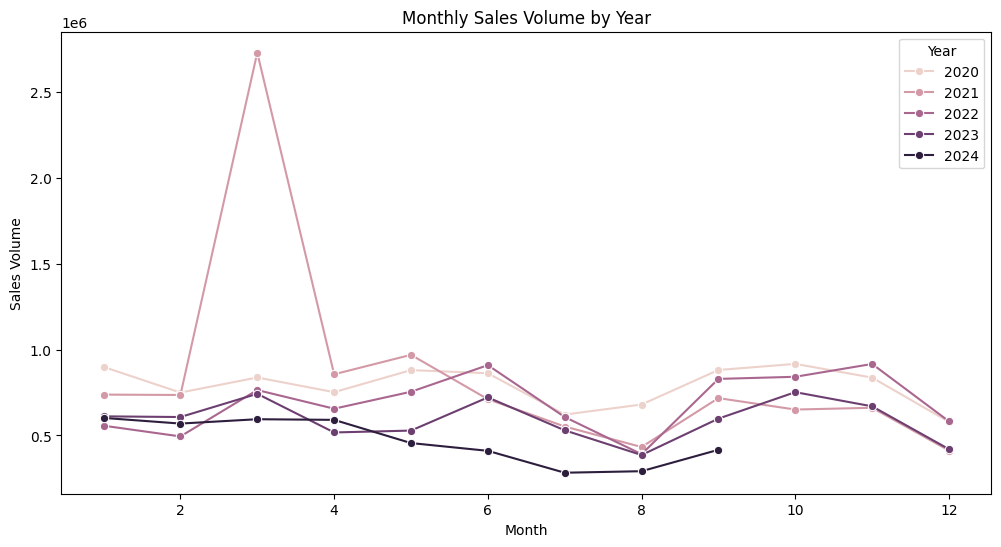

In [9]:
# Plotting sales volume by month for each year to observe trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='volume', hue='year', data=monthly_sales_volume, marker='o')
plt.title('Monthly Sales Volume by Year')
plt.xlabel('Month')
plt.ylabel('Sales Volume')
plt.legend(title='Year')
plt.show()

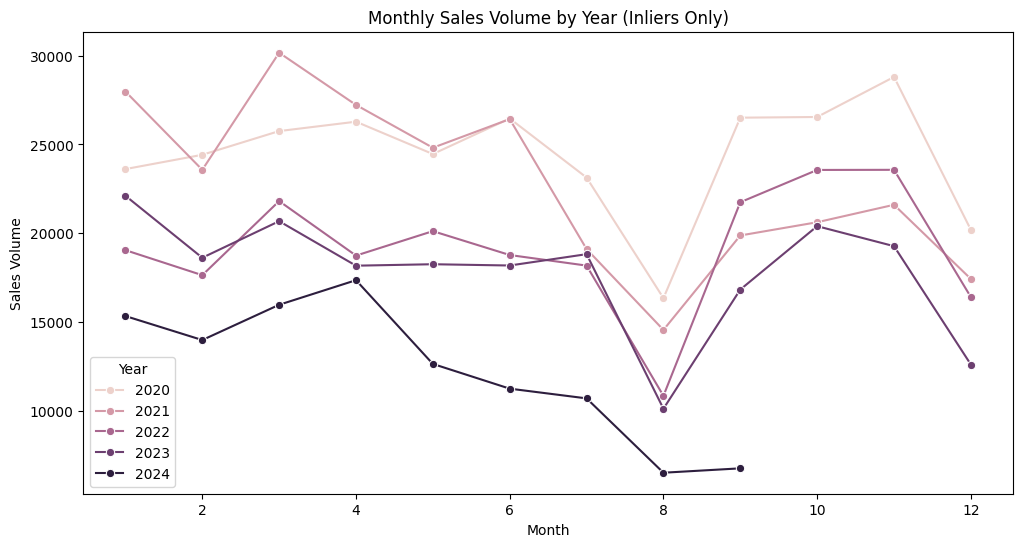

In [10]:
#check monthly sales volume by year with inliers only
monthly_sales_volume_inliers = inliers_df.groupby(['year', 'month'])['volume'].sum().reset_index()

# Plotting sales volume by month for each year to observe trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='volume', hue='year', data=monthly_sales_volume_inliers, marker='o')
plt.title('Monthly Sales Volume by Year (Inliers Only)')
plt.xlabel('Month')
plt.ylabel('Sales Volume')
plt.legend(title='Year')
plt.show()


In [11]:
# Calculate profit margin for each transaction
df_ut['profit_margin'] = (df_ut['sum2'] - df_ut['sum1']) / df_ut['sum1']


In [24]:
# Ensure 'cluster' column exists in df_ut
if 'cluster' not in df_ut.columns:
    # Perform KMeans clustering again if 'cluster' column is missing
    kmeans = KMeans(n_clusters=k_optimal, random_state=42)
    df_ut['cluster'] = kmeans.fit_predict(data_scaled)  # Using the log-transformed, scaled data

# Step 1: Replace near-zero values in `sum1` with NaN for profit_margin calculation
df_ut['profit_margin'] = np.where(df_ut['sum1'] > 1e-6, (df_ut['sum2'] - df_ut['sum1']) / df_ut['sum1'], np.nan)

# Step 2: Aggregate data by cluster to get total volume and average profit margin per cluster, excluding NaN values
cluster_analysis = df_ut.groupby('cluster').agg(
    total_volume=('volume', 'sum'),
    avg_profit_margin=('profit_margin', 'mean')  # NaN values are ignored in the mean calculation
).reset_index()

print("Cluster Analysis (Total Volume and Average Profit Margin):")
print(cluster_analysis)



Cluster Analysis (Total Volume and Average Profit Margin):
   cluster  total_volume  avg_profit_margin
0        0       2539349           0.171880
1        1       1084607           0.028991
2        2      35647822           0.047848


In [25]:
# Calculate correlation
correlation = cluster_analysis['total_volume'].corr(cluster_analysis['avg_profit_margin'])
print("Correlation between Total Volume and Average Profit Margin:", correlation)


Correlation between Total Volume and Average Profit Margin: -0.3566006750081085


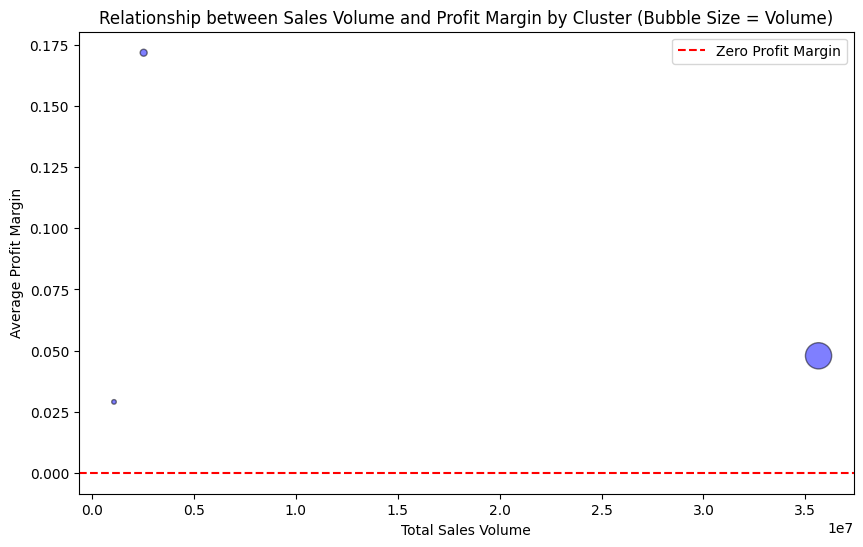

In [28]:
# Bubble Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    x=cluster_analysis['total_volume'],
    y=cluster_analysis['avg_profit_margin'],
    s=cluster_analysis['total_volume'] / 1e5,  # Scale the bubble size by total volume
    alpha=0.5,
    color="blue",
    edgecolor="black"
)
plt.title("Relationship between Sales Volume and Profit Margin by Cluster (Bubble Size = Volume)")
plt.xlabel("Total Sales Volume")
plt.ylabel("Average Profit Margin")
plt.axhline(0, color="red", linestyle="--", label="Zero Profit Margin")
plt.legend()
plt.show()
